# Jet matching using pre-made functions (5X)
## Here we use pre-made functions as found in jet_matching_functions.py . uproot is used to handle the read in of .root files without the need of having ROOT installed locally. The library can actually be used to write-out now as well, but this is not used here.

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mplhep as hep

from collections import Counter
from jet_matching_functions import *

In [2]:
# set plot style
plt.style.use([hep.style.ATLAS,
                   {'font.sans-serif': ['Tex Gyre Heros']},  # use when helvetica isn't installed
                   {'errorbar.capsize': 5},
                   {'axes.labelsize': 23},
                   {'axes.labelpad': 23},
    ])


Below we use a sample of 10,000 events from an ntuple made by the xAOD framework (with our extra truth package added)

In [3]:
fname = 'DAODtoNTUPLE_10000_newest.root'
file = uproot.open(fname)

Output the branches we have in our ROOT file. Note here that we have a4, a10 and a15 samples which refer to anti-kt algorithm with R = 0.4, 1.0 and reconstructed 1.5 resepectively. <br />
MET_Truth_met is the Truth MET information, truthBSM_*variable* refers to some truthBSM particle information

In [4]:
file['outTree;1']['nominal'].keys()

[b'runNumber',
 b'eventNumber',
 b'lumiBlock',
 b'coreFlags',
 b'bcid',
 b'mcEventNumber',
 b'mcChannelNumber',
 b'mcEventWeight',
 b'mcEventWeights',
 b'timeStamp',
 b'timeStampNSOffset',
 b'TileError',
 b'SCTError',
 b'LArError',
 b'TileFlags',
 b'SCTFlags',
 b'LArFlags',
 b'eventClean_LooseBad',
 b'NPV',
 b'actualInteractionsPerCrossing',
 b'averageInteractionsPerCrossing',
 b'weight_pileup',
 b'correctedAverageMu',
 b'correctedAndScaledAverageMu',
 b'correctedActualMu',
 b'correctedAndScaledActualMu',
 b'weight_pileup_up',
 b'weight_pileup_down',
 b'rand_run_nr',
 b'rand_lumiblock_nr',
 b'passL1',
 b'passHLT',
 b'passedTriggers',
 b'disabledTriggers',
 b'na4_pflowjets_raw',
 b'a4_pflowjets_raw_E',
 b'a4_pflowjets_raw_pt',
 b'a4_pflowjets_raw_phi',
 b'a4_pflowjets_raw_eta',
 b'a4_pflowjets_raw_clean_passLooseBad',
 b'a4_pflowjets_raw_clean_passTightBad',
 b'a4_pflowjets_raw_numConstituents',
 b'a4_pflowjets_raw_ConeTruthLabelID',
 b'a4_pflowjets_raw_TruthCount',
 b'a4_pflowjets_raw_

Sets the tree we want to look at (nominal is the interesting one!)

In [5]:
tree = file['outTree']['nominal']

In [6]:
numBSM_truth = tree.array('ntruthBSM')
truthBSM_pdgIDs = tree.array('truthBSM_pdgId')
truthBSM_status = tree.array('truthBSM_status')
truthBSM_barcode = tree.array('truthBSM_barcode')
truthBSM_px = tree.array('truthBSM_px')
truthBSM_py = tree.array('truthBSM_py')
truthBSM_pz = tree.array('truthBSM_pz')
truthBSM_m = tree.array('truthBSM_m')
truthBSM_pt = tree.array('truthBSM_pt')

## Functions to be used
Here we define the functions that will aid in visualization and matching. These can be found in the jet_matching_functions.py, but for ease of modification of values (xlim, ylim, etc.) they are included here as well <br />
- make_truth_matched_var: this takes the variable we are interested in and looks for the value and position in the deltaR_lt_pos. deltaR_lt refers to the deltaR less than whatever value is set for it <br />
- make_plot_data: takes in the truth matched data and makes the data that is to be plotted <br />
- atlas_plotter: handles plotting in an ATLAS style <br />
- jet_match: handles the actual jet matching based on truth and reconstructed collections of values. We also set our deltaR limit here. For R=0.4, a deltaR limit of 0.2 is used, for example

In [7]:
def make_truth_matched_var(deltaR_lt_pos, var):
    truth_match_var = []
    for i in range(len(deltaR_lt_pos)):
        temp = []
        try:
            for j in deltaR_lt_pos[i]:
                if deltaR_lt_pos[i] != []:
                    temp.append(var[j[0], j[1]])
                else:
                    temp.append(-999)
        except:
            temp.append(-999)

        truth_match_var.append(temp)

    return truth_match_var

In [8]:
def make_plot_data(truth_matched_var):
    data = []
    for i in range(len(truth_matched_var)):
        for j in truth_matched_var[i]:
            data.append(j)
    return data

In [9]:
def atlas_plotter(data, xlabel, legend = '', title = '',bins = 'auto', ylabel = 'Count', 
                  color = 'blue', xlim = (0, 0), ylim = (0, 0), save_plot = False, binwidth = None):
    # set plot style
    plt.style.use([hep.style.ATLAS,
                   {'font.sans-serif': ['Tex Gyre Heros']},  # use when helvetica isn't installed
                   {'errorbar.capsize': 5},
                   {'axes.labelsize': 23},
                   {'axes.labelpad': 23},
    ])

    plt.figure(figsize = (10, 7))
    plt.title(title)
    plt.xlabel(xlabel)
    if xlim != (0, 0):
        plt.xlim(xlim)
    if ylim != (0, 0):
        plt.ylim(ylim)
    sns.histplot(data, bins = bins, color = color, binwidth = binwidth, label = legend)
    plt.legend()

    plt.show()
    if save_plot:
        save_path = title + '.png'
        plt.savefig(save_path)

In [21]:
def jet_match(tree, truth_col, reco_col, deltaR_lim = 0.2):
#set the number of jets we want to loop over 
    num_jets = 4
#define our collection strings
    tru_e = truth_col + '_e'
    tru_pt = truth_col + '_pt'
    tru_phi = truth_col + '_phi'
    tru_eta = truth_col + '_eta'

    rec_pt = reco_col + '_pt'
    rec_phi = reco_col + '_phi'
    rec_eta = reco_col + '_eta'

#make arrays from those collections
    truth_col_e = tree.array(tru_e)
    truth_col_pt = tree.array(tru_pt)
    truth_col_phi = tree.array(tru_phi)
    truth_col_eta = tree.array(tru_eta)

    reco_col_pt = tree.array(rec_pt)
    reco_col_phi = tree.array(rec_phi)
    reco_col_eta = tree.array(rec_eta)

#make the deltaR and deltaR positions arrays
    deltaR_lt = []
    deltaR_lt_pos = []
    for event in range(len(reco_col_phi)):
        temp1 = []
        temp2 = []
        try:
            for jet in range(num_jets):
                for obj in range(len(truth_col_phi[event])):
                    delta_phi = truth_col_phi[event][obj] - reco_col_phi[event][jet]
                    delta_eta = truth_col_eta[event][obj] - reco_col_eta[event][jet]
                    
                    delta_phi_sqrd = delta_phi ** 2
                    delta_eta_sqrd = delta_eta ** 2

                    deltaR_sqrd = delta_phi_sqrd + delta_eta_sqrd
                    deltaR = deltaR_sqrd ** 0.5

                    deltaR_lim = deltaR_lim
                    if deltaR <= deltaR_lim:
                        temp1.append([jet, deltaR])
                        temp2.append([jet, event, obj])
                    else:
                        continue
            deltaR_lt.append(temp1)
            deltaR_lt_pos.append(temp2)
        except:
            deltaR_lt.append([-999, -999])
            deltaR_lt_pos.append([-999, -999, -999])


#number of matched per jet graph
    #save_plot = False
    num_deltaR_lt_1 = []
    num_deltaR_lt_2 = []
    num_deltaR_lt_3 = []
    num_deltaR_lt_4 = []
    for i in range(len(deltaR_lt)):
        temp1 = 0
        temp2 = 0
        temp3 = 0
        temp4 = 0
        try:
            for j in range(len(deltaR_lt[i])):
                if deltaR_lt[i][j][0] == 0:
                    temp1+=1
                elif deltaR_lt[i][j][0] == 1:
                    temp2+=1
                elif deltaR_lt[i][j][0] == 2:
                    temp3+=1
                elif deltaR_lt[i][j][0] == 3:
                    temp4+=1
                    
            num_deltaR_lt_1.append(temp1)
            num_deltaR_lt_2.append(temp2)
            num_deltaR_lt_3.append(temp3)
            num_deltaR_lt_4.append(temp4)
        except:
            continue
            
    #title = 'Number of Truth Matched Particles per Event Histogram Plot: '+truth_col+' vs '+reco_col
    #xlabel = 'Num. Jets'
    #atlas_plotter(num_deltaR_lt, title, xlabel, save_plot = save_plot)

#make our truth matched variables
    #truth_matched_e = make_truth_matched_var(deltaR_lt02_pos, reco_col_e)
    truth_matched_pt = make_truth_matched_var(deltaR_lt_pos, reco_col_pt)
    #truth_matched_eta = make_truth_matched_var(deltaR_lt_pos, reco_col_eta)
    #truth_matched_phi = make_truth_matched_var(deltaR_lt_pos, reco_col_phi)

#let's make us some plots
    #data_e = make_plot_data(truth_matched_e)
    data_pt = make_plot_data(truth_matched_pt)
    #data_eta = make_plot_data(truth_matched_eta)
    #data_phi = make_plot_data(truth_matched_phi)
    
    #try:
        #rec_e = reco_col + '_E'
        #reco_col_e = tree.array(rec_e)
        #truth_matched_e = make_truth_matched_var(deltaR_lt_pos, reco_col_e)
        #data_e = make_plot_data(truth_matched_e)
    #except:
        #pass
    
    return deltaR_lt, deltaR_lt_pos, num_deltaR_lt_1, num_deltaR_lt_2, num_deltaR_lt_3, num_deltaR_lt_4, reco_col_pt, truth_matched_pt, data_pt

Below we perform the actual matching

In [22]:
deltaR_lt, deltaR_lt_pos, num_deltaR_lt_1, num_deltaR_lt_2, num_deltaR_lt_3, num_deltaR_lt_4, reco_col_pt, truth_matched_pt, data_pt = jet_match(tree, 'truthBSM', 'a4_pflowjets_raw', deltaR_lim = 0.2)

In [13]:
truthBSM_matched_jets_pdgid = []
for i in range(len(deltaR_lt_pos)):
    temp = []
    try:
        for j in deltaR_lt_pos[i]:
            if deltaR_lt_pos[i] != []:
                temp.append([j[0], truthBSM_pdgIDs[j[1], j[2]]])
            else:
                temp.append(-999)
    except:
        temp.append(-999)
        
    truthBSM_matched_jets_pdgid.append(temp)

In [21]:
num_51_1 = []
num_51_2 = []
num_51_3 = []
num_51_4 = []
particle_list = [51, -51]
for i in truthBSM_matched_jets_pdgid:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    temp4 = 0
    try:
        for j in i:
            if (j[1] in particle_list):
                if j[0] == 0:
                    temp1+=1
                elif j[0] == 1:
                    temp2+=1
                elif j[0] == 2:
                    temp3+=1
                elif j[0] == 3:
                    temp4+=1
        num_51_1.append(temp1)
        num_51_2.append(temp2)
        num_51_3.append(temp3)
        num_51_4.append(temp4)
    except:
        continue

In [22]:
num_53_1 = []
num_53_2 = []
num_53_3 = []
num_53_4 = []
particle_list = [53, -53]
for i in truthBSM_matched_jets_pdgid:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    temp4 = 0
    try:
        for j in i:
            if (j[1] in particle_list):
                if j[0] == 0:
                    temp1+=1
                elif j[0] == 1:
                    temp2+=1
                elif j[0] == 2:
                    temp3+=1
                elif j[0] == 3:
                    temp4+=1
        num_53_1.append(temp1)
        num_53_2.append(temp2)
        num_53_3.append(temp3)
        num_53_4.append(temp4)
    except:
        continue

## Visualisations 
Here we visualise some distributions in our data. Initially we are interested in total number of truth matched BSM particles to jets 1, 2, 3 and 4. Later we look at the same but with some specific particle PDGIds namely: <br />
- 51: Spin-0 Dark Matter candidate <br />
- 53: Spin-1 Dark Matter candidate 

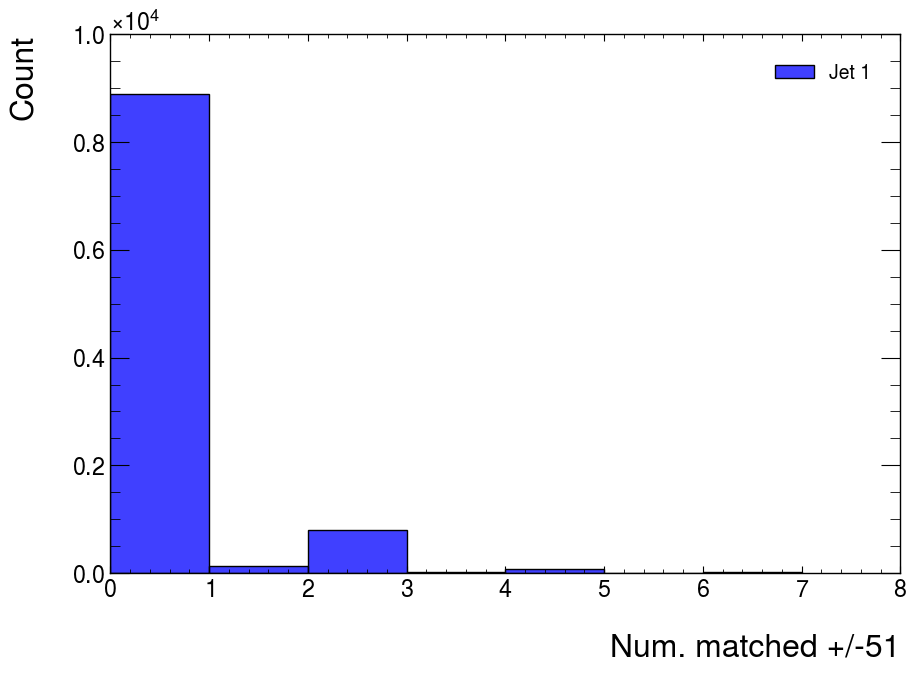

In [153]:
title = 'Total Number of Truth Matched +/-51 to Jet 1: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-51'
atlas_plotter(num_51_1, xlabel = xlabel, legend = 'Jet 1', binwidth = 1, xlim = (0, 8), ylim = (0, 1e4))

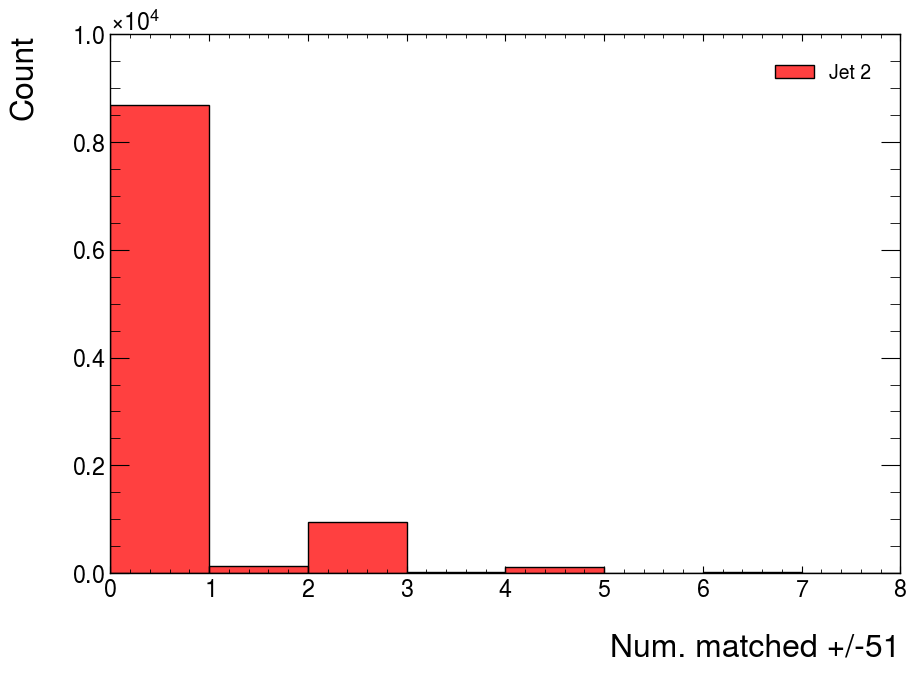

In [152]:
title = 'Total Number of Truth Matched +/-51 to Jet 2: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-51'
atlas_plotter(num_51_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 8), ylim = (0, 1e4))

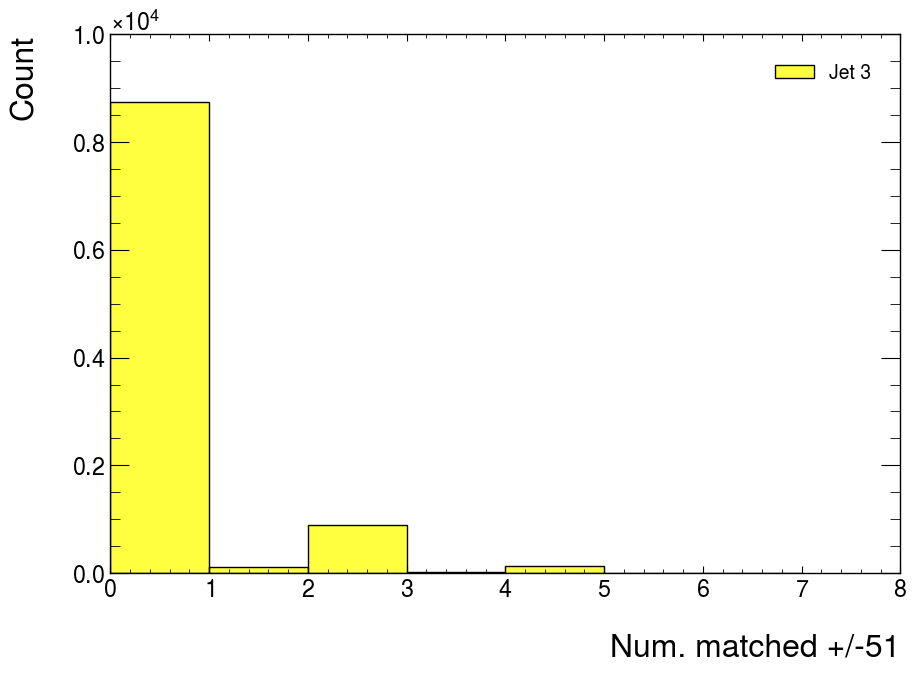

In [151]:
title = 'Total Number of Truth Matched +/-51 to Jet 3: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-51'
atlas_plotter(num_51_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 8), ylim = (0, 1e4))

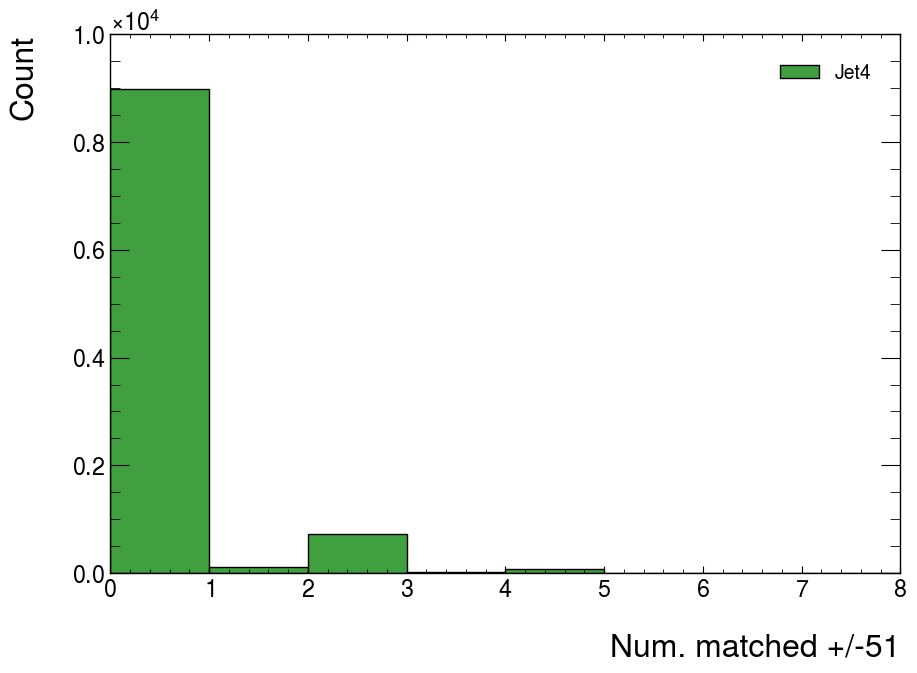

In [147]:
title = 'Total Number of Truth Matched +/-51 to Jet 4: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-51'
atlas_plotter(num_51_4, xlabel, legend = 'Jet4', binwidth = 1, color = 'green', ylim = (0, 1e4))

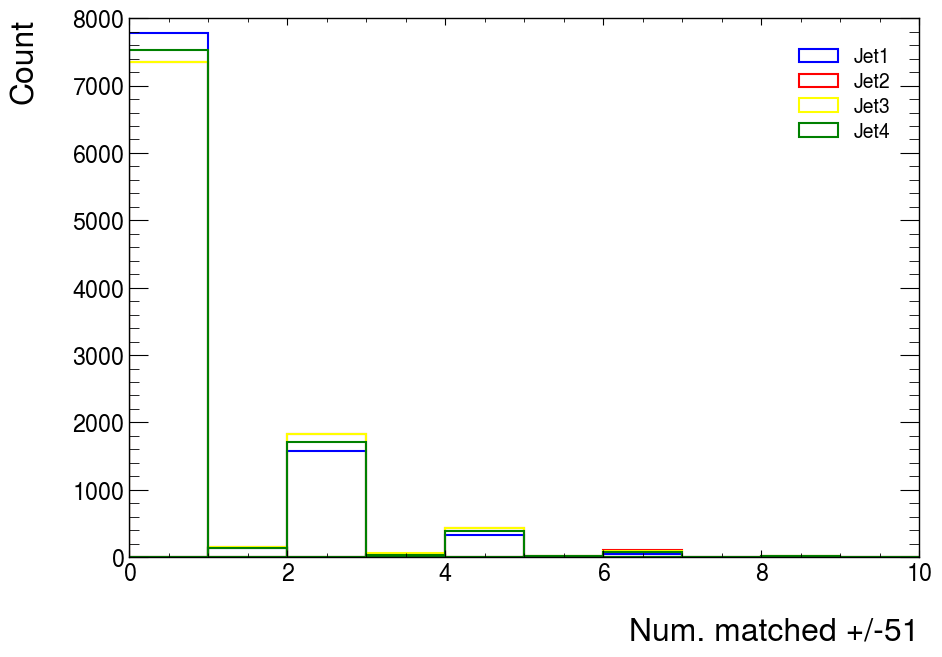

In [25]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. matched +/-51')
plt.ylim(0, 8e3)
plt.xlim(0, 10)
sns.histplot(num_51_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_51_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_51_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_51_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

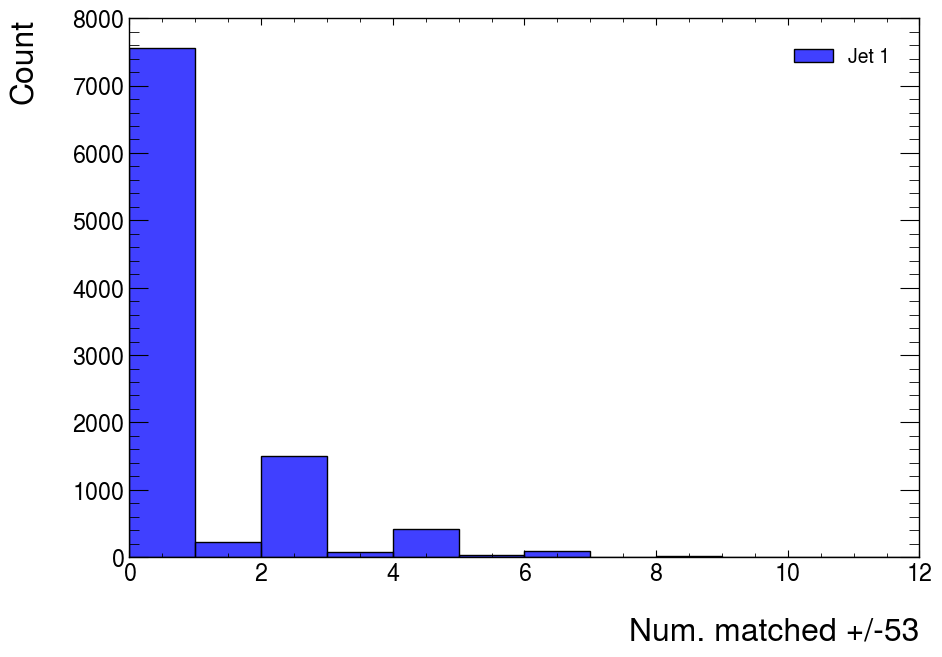

In [160]:
title = 'Total Number of Truth Matched +/-53 to Jet 1: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-53'
atlas_plotter(num_53_1, xlabel = xlabel, legend = 'Jet 1', binwidth = 1, xlim = (0, 12), ylim = (0, 8e3))

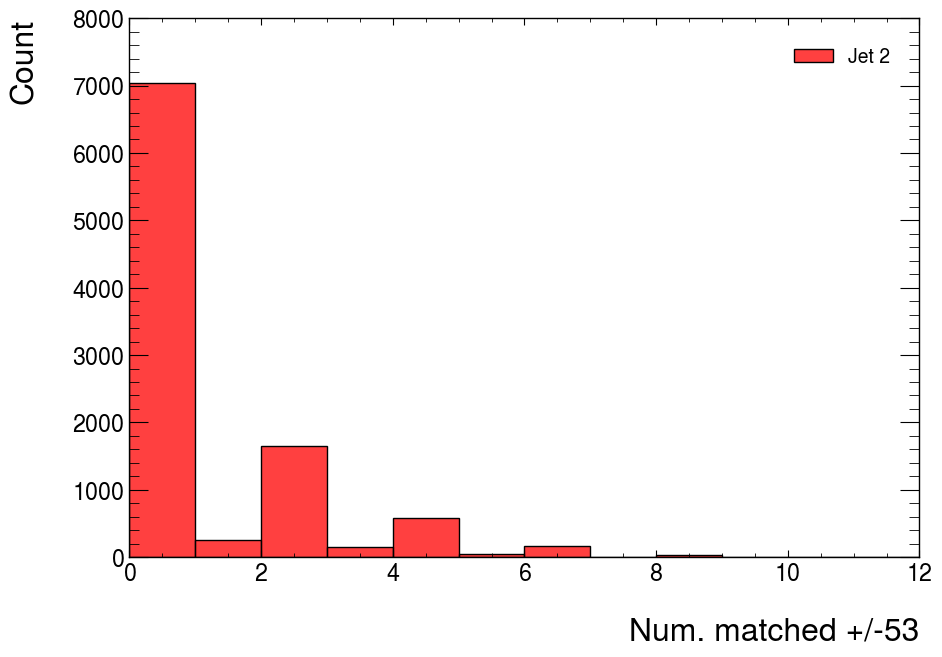

In [159]:
title = 'Total Number of Truth Matched +/-51 to Jet 2: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-53'
atlas_plotter(num_53_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 12), ylim = (0, 8e3))

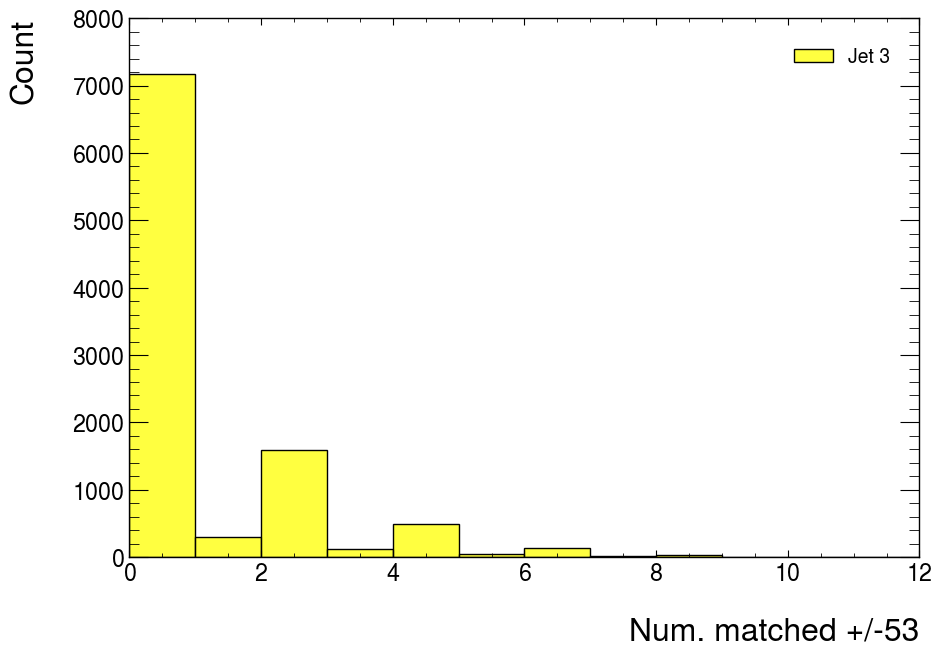

In [158]:
title = 'Total Number of Truth Matched +/-51 to Jet 3: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-53'
atlas_plotter(num_53_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 12), ylim = (0, 8e3))

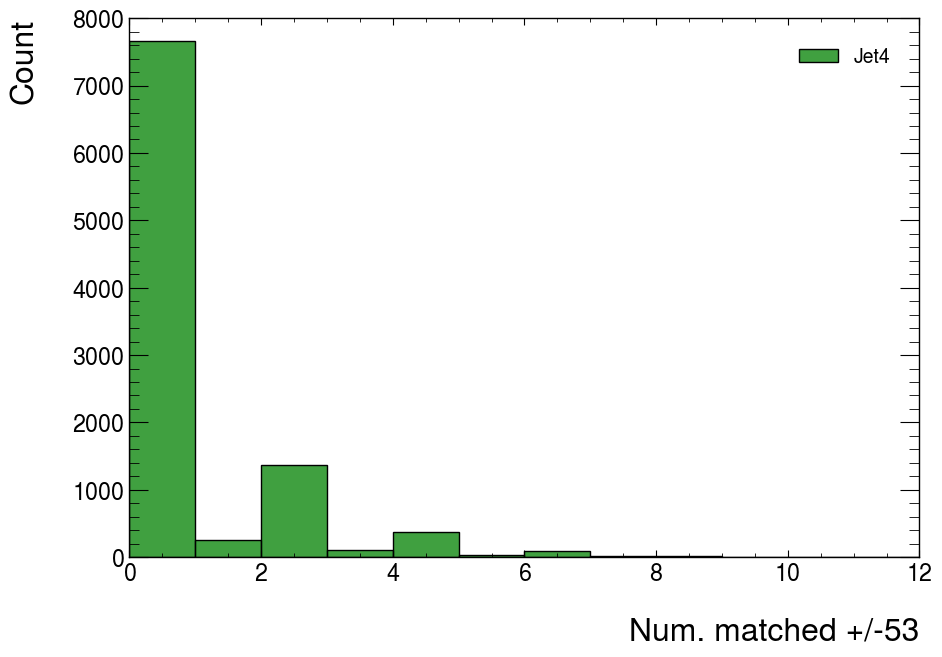

In [157]:
title = 'Total Number of Truth Matched +/-51 to Jet 4: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-53'
atlas_plotter(num_53_4, xlabel, legend = 'Jet4', binwidth = 1, color = 'green', xlim = (0, 12), ylim = (0, 8e3))

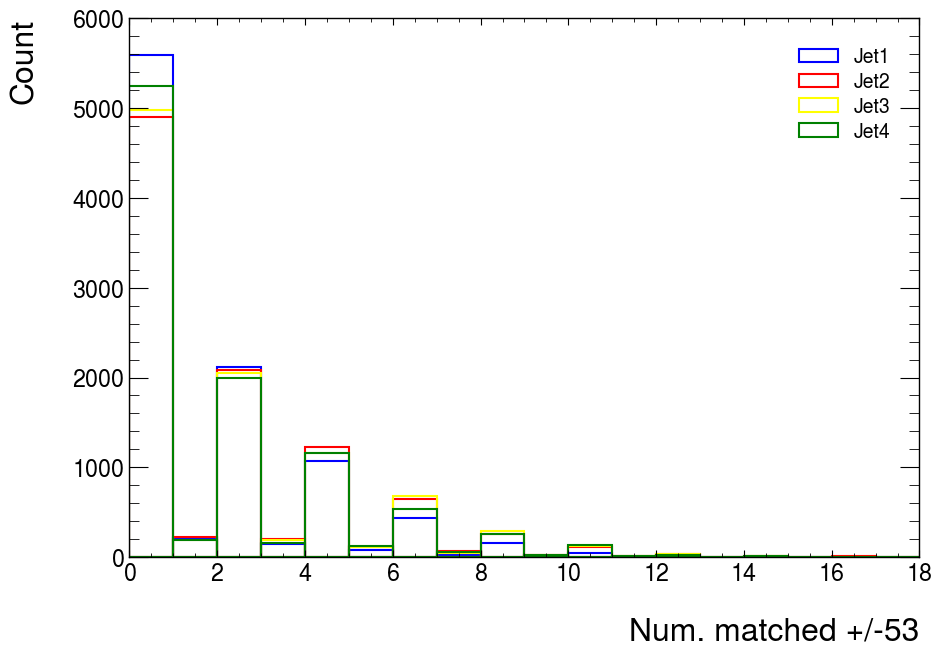

In [26]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. matched +/-53')
plt.ylim(0, 6e3)
plt.xlim(0, 18)
sns.histplot(num_53_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_53_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_53_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_53_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

## How many jets are matched to?
We now move on to getting an idea of how many times we have 1 jet matched to at least 1 BSM particle, at least 2 jets matched to at least 1 particle each, and then the break down of which jets they are matching to. 

We want to find out which of these jets specifically those truth matched particles are matched to in the 'at least 2 jets matched to at least 1 each' case. <br />
'XnY' refers to the jets that the matches happen to ie 1n2 -> jets 1 (a)n(d) 2. <br />
We are following essentially the same process as the previous, except with some extra conditional logic that splits down into different jet combinations

In [107]:
match_2to1_1n2_51 = []
match_2to1_1n3_51 = []
match_2to1_1n4_51 = []
match_2to1_2n3_51 = []
match_2to1_2n4_51 = []
match_2to1_3n4_51 = []
particle_list = [51, -51]
for i in range(len(deltaR_lt_pos)):
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] in particle_list):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2_51.append(temp12)
        match_2to1_1n3_51.append(temp13)
        match_2to1_1n4_51.append(temp14)
        match_2to1_2n3_51.append(temp23)
        match_2to1_2n4_51.append(temp24)
        match_2to1_3n4_51.append(temp34)
    except: 
        match_2to1_1n2_51.append(0)
        match_2to1_1n3_51.append(0)
        match_2to1_1n4_51.append(0)
        match_2to1_2n3_51.append(0)
        match_2to1_2n4_51.append(0)
        match_2to1_3n4_51.append(0)

In [108]:
match_2to1_1n2_53 = []
match_2to1_1n3_53 = []
match_2to1_1n4_53 = []
match_2to1_2n3_53 = []
match_2to1_2n4_53 = []
match_2to1_3n4_53 = []
particle_list = [53, -53]
for i in range(len(deltaR_lt_pos)):
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] in particle_list):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2_53.append(temp12)
        match_2to1_1n3_53.append(temp13)
        match_2to1_1n4_53.append(temp14)
        match_2to1_2n3_53.append(temp23)
        match_2to1_2n4_53.append(temp24)
        match_2to1_3n4_53.append(temp34)
    except: 
        match_2to1_1n2_53.append(0)
        match_2to1_1n3_53.append(0)
        match_2to1_1n4_53.append(0)
        match_2to1_2n3_53.append(0)
        match_2to1_2n4_53.append(0)
        match_2to1_3n4_53.append(0)

In [109]:
match_2to1_1n2_51_true = 0
match_2to1_1n3_51_true = 0
match_2to1_1n4_51_true = 0
match_2to1_2n3_51_true = 0
match_2to1_2n4_51_true = 0
match_2to1_3n4_51_true = 0
for i in range(len(match_2to1_1n2_51)):
    if match_2to1_1n2_51[i] == 1:
        match_2to1_1n2_51_true+=1
    if match_2to1_1n3_51[i] == 1:
        match_2to1_1n3_51_true+=1
    if match_2to1_1n4_51[i] == 1:
        match_2to1_1n4_51_true+=1
    if match_2to1_2n3_51[i] == 1:
        match_2to1_2n3_51_true+=1
    if match_2to1_2n4_51[i] == 1:
        match_2to1_2n4_51_true+=1
    if match_2to1_3n4_51[i] == 1:
        match_2to1_3n4_51_true+=1

In [110]:
match_2to1_1n2_53_true = 0
match_2to1_1n3_53_true = 0
match_2to1_1n4_53_true = 0
match_2to1_2n3_53_true = 0
match_2to1_2n4_53_true = 0
match_2to1_3n4_53_true = 0
for i in range(len(match_2to1_1n2_53)):
    if match_2to1_1n2_53[i] == 1:
        match_2to1_1n2_53_true+=1
    if match_2to1_1n3_53[i] == 1:
        match_2to1_1n3_53_true+=1
    if match_2to1_1n4_53[i] == 1:
        match_2to1_1n4_53_true+=1
    if match_2to1_2n3_53[i] == 1:
        match_2to1_2n3_53_true+=1
    if match_2to1_2n4_53[i] == 1:
        match_2to1_2n4_53_true+=1
    if match_2to1_3n4_53[i] == 1:
        match_2to1_3n4_53_true+=1

In [111]:
match_2to1_51 = [] 
for i in range(len(deltaR_lt_pos)):
    temp = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 51) or (particles[k] == -51):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            temp = 1
        match_2to1_51.append(temp)
    except: 
        match_2to1_51.append(0)

In [112]:
match_2to1_51_true = 0
for i in range(len(match_2to1_51)):
    if match_2to1_51[i] == 1:
        match_2to1_51_true+=1

In [113]:
percent_2to1_51 = round(match_2to1_51_true/len(match_2to1_51), 4) * 100

In [114]:
match_2to1_53 = [] 
for i in range(len(deltaR_lt_pos)):
    temp = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 53) or (particles[k] == -53):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            temp = 1
        match_2to1_53.append(temp)
    except: 
        match_2to1_53.append(0)

In [115]:
match_2to1_53_true = 0
for i in range(len(match_2to1_53)):
    if match_2to1_53[i] == 1:
        match_2to1_53_true+=1

In [116]:
percent_2to1_53 = round(match_2to1_53_true/len(match_2to1_53), 4) * 100

In [117]:
percent_2to1_1n2_51 = round(match_2to1_1n2_51_true/len(match_2to1_1n2_51), 4)*100
percent_2to1_1n3_51 = round(match_2to1_1n3_51_true/len(match_2to1_1n3_51), 4)*100
percent_2to1_1n4_51 = round(match_2to1_1n4_51_true/len(match_2to1_1n4_51), 4)*100
percent_2to1_2n3_51 = round(match_2to1_2n3_51_true/len(match_2to1_2n3_51), 4)*100
percent_2to1_2n4_51 = round(match_2to1_2n4_51_true/len(match_2to1_2n4_51), 4)*100
percent_2to1_3n4_51 = round(match_2to1_3n4_51_true/len(match_2to1_3n4_51), 4)*100

In [118]:
percent_2to1_1n2_53 = round(match_2to1_1n2_53_true/len(match_2to1_1n2_53), 4)*100
percent_2to1_1n3_53 = round(match_2to1_1n3_53_true/len(match_2to1_1n3_53), 4)*100
percent_2to1_1n4_53 = round(match_2to1_1n4_53_true/len(match_2to1_1n4_53), 4)*100
percent_2to1_2n3_53 = round(match_2to1_2n3_53_true/len(match_2to1_2n3_53), 4)*100
percent_2to1_2n4_53 = round(match_2to1_2n4_53_true/len(match_2to1_2n4_53), 4)*100
percent_2to1_3n4_53 = round(match_2to1_3n4_53_true/len(match_2to1_3n4_53), 4)*100

In [119]:
data = [['Jets (A4 51)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2_51, percent_2to1_1n3_51, percent_2to1_1n4_51], 
        [2,           0,          0,       percent_2to1_2n3_51, percent_2to1_2n4_51], 
        [3,           0,          0,                0,       percent_2to1_3n4_51], 
        [4,           0,          0,                0,                0      ]]

The visualization here allows us to view the percentages at a glance. Notice that we have A4 which refers to the AntiKt4 jets.

In [120]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A4 51),1,2,3,4
1,0,1.49,1.24,1.08
2,0,0,1.34,1.15
3,0,0,0,1.05
4,0,0,0,0


In [121]:
data = [['Jets (A4 53)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2_53, percent_2to1_1n3_53, percent_2to1_1n4_53], 
        [2,           0,          0,       percent_2to1_2n3_53, percent_2to1_2n4_53], 
        [3,           0,          0,                0,       percent_2to1_3n4_53], 
        [4,           0,          0,                0,                0      ]]

In [122]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A4 53),1,2,3,4
1,0,7.23,6.73,5.72
2,0,0,6.8,6.31
3,0,0,0,6.03
4,0,0,0,0


Moving on to more descriptive tables, rather than just percentages

In [123]:
match_1to1 = []
for i in deltaR_lt_pos:
    if len(i) != 0:
        match_1to1.append(1)
    else:
        match_1to1.append(0)
        
match_2to1each = []
num = 0
for evt in deltaR_lt_pos:
    temp = 0
    temp2 = []
    try:
        for obj in evt:
            temp2.append(obj[0])
        count = Counter(temp2)
        if len(count.keys()) >= 2:
            temp = 1
        else:
            temp = 0
        match_2to1each.append(temp)
    except:
        match_2to1each.append(-999)

In [124]:
match_1to1_true = 0
match_2to1each_true = 0
for i in range(len(match_1to1)):
    if match_1to1[i] == 1:
        match_1to1_true+=1
    if match_2to1each[i] == 1:
        match_2to1each_true+=1

In [125]:
percent_1to1 = round(match_1to1_true/len(match_1to1)*100, 2)

In [126]:
percent_2to1 = round(match_2to1each_true/len(match_2to1each)*100, 2)

In [127]:
match_1to1_51 = []
for i in range(len(deltaR_lt_pos)):
    temp1 = 0
    try:
        for j in range(len(deltaR_lt_pos[i])):
            if (truthBSM_matched_jets_pdgid[i][j][1] == 51) or (truthBSM_matched_jets_pdgid[i][j][1] == -51):             temp1 = 1
        match_1to1_51.append(temp1)
    except:
        match_1to1_51.append(0)

In [128]:
match_1to1_51_true = 0
for i in range(len(match_1to1_51)):
    if match_1to1_51[i] == 1:
        match_1to1_51_true+=1

In [129]:
match_1to1_53 = []
for i in range(len(deltaR_lt_pos)):
    temp1 = 0
    try:
        for j in range(len(deltaR_lt_pos[i])):
            if (truthBSM_matched_jets_pdgid[i][j][1] == 53) or (truthBSM_matched_jets_pdgid[i][j][1] == -53):             temp1 = 1
        match_1to1_53.append(temp1)
    except:
        match_1to1_53.append(0)

In [130]:
match_1to1_53_true = 0
for i in range(len(match_1to1_53)):
    if match_1to1_53[i] == 1:
        match_1to1_53_true+=1

In [132]:
percent_1to1_51 = round(match_1to1_51_true/len(match_1to1_51)* 100, 2)

In [134]:
percent_1to1_53 = round(match_1to1_53_true/len(match_1to1_53)* 100, 2)

In [135]:
df_dict = {'Num. events with at least 1 jet matched to at least 1 particle' : match_1to1_true, 
           'Percentage of 1 jet matched to at least 1 particle' : percent_1to1, 
           'Num. events with at least 1 +/-51 particle matched to at least 1 jet': match_1to1_51_true,
           'Percentage of 1 jet matched to at least 1 +/-51 particle' : percent_1to1_51,
           'Num. events with at least 2 jets matched to at least 1 particle each' : match_2to1each_true, 
           'Percentage of 2 jets matched to at least 1 particle each' : percent_2to1, 
           'Num. events with at least 2 +/-51 particles matched to 2 different jets' : match_2to1_51_true,
           'Percentage of 2 jets matched to at least 1 +/-51 particle each' : percent_2to1_51}

In [136]:
columns = ['Description', 'Num. Events', 'Percentage']
descriptions = ['At least 1 jet matched to at least 1 BSM', 
                'At least 1 jet matched to at least 1 +/-51 particle each', 
                'At least 2 jets matched to at least 1 particle each', 
                'At least 2 jets matched to at least 1 +/-51 particle each']

In [137]:
data = np.array(list(df_dict.values())).reshape((-1, 2))

In [138]:
df = pd.DataFrame(data, columns = columns[1:])

In [139]:
df.insert(loc = 0, column = columns[0], value = descriptions)

In [140]:
df.style.hide_index()

Description,Num. Events,Percentage
At least 1 jet matched to at least 1 BSM,9731,97.78
At least 1 jet matched to at least 1 +/-51 particle each,3759,37.77
At least 2 jets matched to at least 1 particle each,8476,85.17
At least 2 jets matched to at least 1 +/-51 particle each,631,6.34


In [141]:
df_dict = {'Num. events with at least 1 jet matched to at least 1 particle' : match_1to1_true, 
           'Percentage of 1 jet matched to at least 1 particle' : percent_1to1, 
           'Num. events with at least 1 +/-4900101 particle matched to at least 1 jet': match_1to1_53_true,
           'Percentage of 1 jet matched to at least 1 +/-4900101 particle' : percent_1to1_53,
           'Num. events with at least 2 jets matched to at least 1 particle each' : match_2to1each_true, 
           'Percentage of 2 jets matched to at least 1 particle each' : percent_2to1, 
           'Num. events with at least 2 +/-4900101 particles matched to 2 different jets' : match_2to1_53_true,
           'Percentage of 2 jets matched to at least 1 +/-4900101 particle each' : percent_2to1_53}

In [142]:
columns = ['Description', 'Num. Events', 'Percentage']
descriptions = ['At least 1 jet matched to at least 1 BSM', 
                'At least 1 jet matched to at least 1 +/-53 particle each', 
                'At least 2 jets matched to at least 1 particle each', 
                'At least 2 jets matched to at least 1 +/-53 particle each']

In [143]:
data = np.array(list(df_dict.values())).reshape((-1, 2))

In [144]:
df = pd.DataFrame(data, columns = columns[1:])

In [145]:
df.insert(loc = 0, column = columns[0], value = descriptions)

In [146]:
df.style.hide_index()

Description,Num. Events,Percentage
At least 1 jet matched to at least 1 BSM,9731,97.78
At least 1 jet matched to at least 1 +/-53 particle each,7020,70.54
At least 2 jets matched to at least 1 particle each,8476,85.17
At least 2 jets matched to at least 1 +/-53 particle each,2748,27.61


Also can get an idea of how many un-matched 51 and 53 we have

In [115]:
num_51 = []
num_53 = []
particle_list_51 = [51, -51]
particle_list_53 = [53, -53]
for i in truthBSM_pdgIDs:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    try:
        for j in i:
            if (j in particle_list_51):
                temp1+=1
            if (j in particle_list_53):
                temp2+=1
        num_51.append(temp1)
        num_53.append(temp2)
    except:
        continue

No handles with labels found to put in legend.


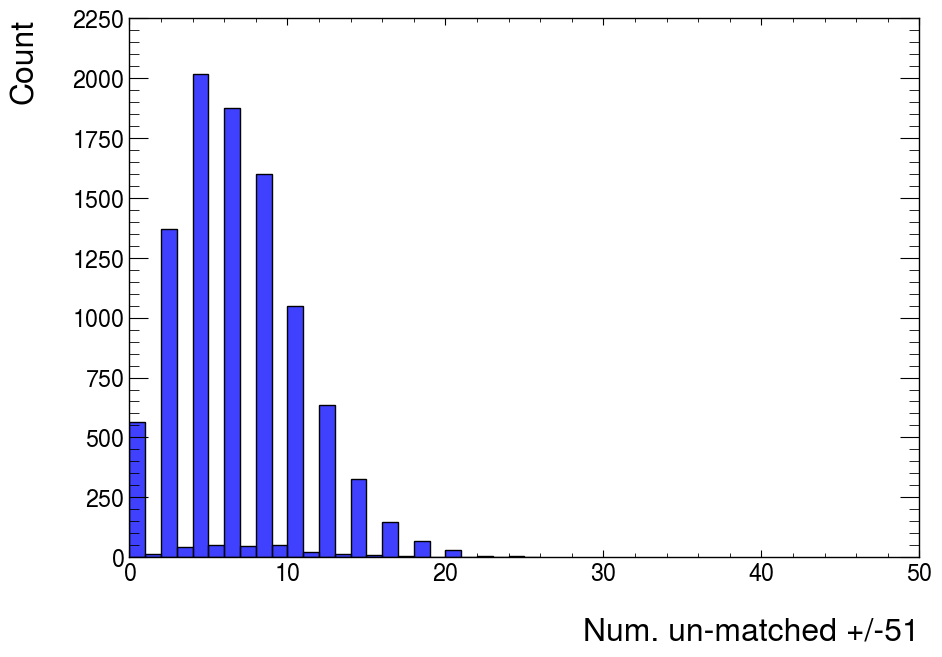

In [116]:
xlabel = 'Num. un-matched +/-51'
atlas_plotter(num_51, xlabel, binwidth = 1, color = 'blue', xlim = (0, 50))

No handles with labels found to put in legend.


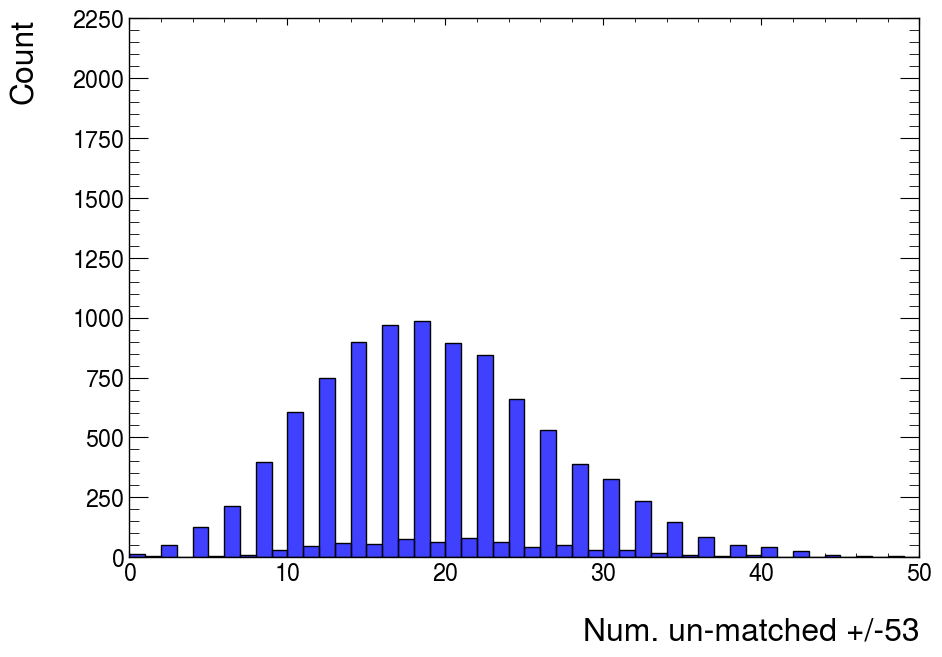

In [117]:
xlabel = 'Num. un-matched +/-53'
atlas_plotter(num_53, xlabel, binwidth = 1, color = 'blue', ylim = (0, 2250), xlim = (0, 50))